In [3]:
import pyvista as pv
from pyvista import examples

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy
import copy
import pandas as pd
import seaborn as sns
from IPython.display import clear_output

import random
import vtk
from vtk import vtkAppendPolyData, vtkPolyDataReader, vtkPolyDataWriter, vtkPolyData, vtkUnstructuredGridReader
from vtk.util.numpy_support import vtk_to_numpy

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



C:\Users\ullri\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [19]:
def write_vtk(points, cell, filename):
    with open(filename, 'w') as f:
        # Write header
        f.write("# vtk DataFile Version 4.2\n")
        f.write("vtk output\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")
        
        # Write points
        num_points = len(points)
        f.write("POINTS {} float\n".format(num_points))
        for point in points:
            f.write("{} {} {}\n".format(point[0], point[1], point[2]))
        
        # Write cells
        num_cells = len(cell)
        total_num_points = np.sum(cell[:, 0])
        f.write("POLYGONS {} {}\n".format(num_cells, total_num_points + num_cells))
        for cell_indices in cell:
            num_indices = cell_indices[0]
            f.write("{} ".format(num_indices))
            for index in cell_indices[1:]:
                f.write("{} ".format(index))
            f.write("\n")

def visualize(nameOfFile):
    # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(nameOfFile)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Create a render window and set the renderer as its active renderer
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(600, 600)
    renderer.ResetCamera()

    # Create an interactor and start the visualization
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    interactor.Start()
    
def readfile(filename):
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(filename)
    reader.Update()

    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    array = points.GetData()
    numpy_nodes = vtk_to_numpy(array)
    #print(numpy_nodes)
    cells = polydata.GetPolys()
    nCells = cells.GetNumberOfCells()
    array = cells.GetData()
    # This holds true if all polys are of the same kind, e.g. triangles.
    assert(array.GetNumberOfValues()%nCells==0)
    nCols = array.GetNumberOfValues()//nCells
    numpy_cells = vtk_to_numpy(array)
    numpy_cells = numpy_cells.reshape((-1,nCols))
    return numpy_cells, numpy_nodes

def rotate_points(points, axis, angle):
    # Normalize the axis vector
    axis = axis / np.linalg.norm(axis)

    # Convert the angle to radians
    angle_rad = np.radians(angle)

    # Compute the cross product matrix of the axis vector
    cross_product_matrix = np.array([
        [0, -axis[2], axis[1]],
        [axis[2], 0, -axis[0]],
        [-axis[1], axis[0], 0]
    ])

    # Compute the rotation matrix using Rodrigues' rotation formula
    rotation_matrix = np.eye(3) + np.sin(angle_rad) * cross_product_matrix + \
                      (1 - np.cos(angle_rad)) * np.dot(cross_product_matrix, cross_product_matrix)

    # Apply the rotation to the points
    rotated_points = np.dot(points, rotation_matrix.T)

    return rotated_points

def modify_teapot(rotate = False,scale = False, noise = False, img = False, spot = False, crackedFactor = 100, minNumOfCracked = 10, maxNumOfCracked = 100):
    teapot = examples.download_teapot()
    PP = teapot.points
    
    if rotate != False:
        axis = np.random.choice([-1,0,1],3)
        print(axis)
        #if axis == np.array([0,0,0]):
        #    axis = np.array([1,1,1])
        angle = np.random.uniform(-360, 360)
        PP = rotate_points(PP, axis, angle)
        
    if scale != False:
        scalefactor = np.random.uniform(1, 2.32)
        PP = PP*scalefactor
    
    if noise != False:
        points =[]
        for p in teapot.points:
            p = p + (2 * np.random.rand(3) - 1)/100
            points.append(p)
        PP = np.array(points)
    
    #teapot.rotate_x(round(np.random.uniform(0, 360)), inplace=True)
    #teapot.rotate_z(round(np.random.uniform(0, 360)), inplace=True)
    #teapot.rotate_y(round(np.random.uniform(0, 360)), inplace=True)
    #teapot.scale(round(np.random.uniform(0, 2), 3), inplace=True)

    
    cells = []
    
    if spot != False:
        print("inside")
        n = np.random.randint(minNumOfCracked, maxNumOfCracked)
        #print("number of points:  ", n)
        mod_points = np.random.choice(np.arange(len(PP)), size=n, replace=False)
        #print(len(mod_points),"top 10 indecies:  ", mod_points[0:10])
        #mod_points = [1]
        #mod_points = np.concatenate((np.array([0,1,2,4]), mod_points), axis = 0)
        #print(mod_points[:10])
        for p in mod_points:
            PP[p] = teapot.points[p] + (2 * np.random.rand(3) - 1)/crackedFactor
            
            distances = np.linalg.norm(PP - PP[p], axis=1)
            # find the indices of the 3 closest points
            indices = np.argpartition(distances, 10)[:10]
            #print("original PP top 10  ", PP[indices][:10], '\n')
            PP[indices] = PP[indices] + (2 * np.random.rand(3) - 1)/crackedFactor
            #print("modified 10 points", PP[indices][:10])
        #PP = teapot.points
        teapot.clear_data()
        #print(PP[:3])
        
        
        
    for i in range(teapot.number_of_cells):
        cells.append(teapot.get_cell(i).point_ids)
    
    if img != False:
        p = pv.Plotter()
        p.add_mesh(teapot)
        p.show()
    
    return teapot, PP, np.array(cells)

def generation(groupsize, Case, cf=100, minc=10, maxc=100):
    Pro = np.zeros((groupsize, 9))
    Total_points = []
    for i in range(groupsize):
        shape, points, mesh = modify_teapot(noise = False, img = False, spot = True, crackedFactor = cf, minNumOfCracked = minc, maxNumOfCracked = maxc)
        #print(points[0:5])
        #print(i)
        Vol = shape.volume
        Area = shape.area
        Center = np.array(shape.center).flatten()
        CenterOfMass = shape.center_of_mass().flatten()
    
        Pro[i] =  np.concatenate(([Case, Vol, Area], Center, CenterOfMass))
        Total_points.append(points)
        
        
    a = shape
    return Pro, a, np.array(Total_points), mesh
        #Total_points[i] = points
        #Total_shapes.append(shape)
#group_size = 10

def processed_shapes(shapes):
    Processed_Points = copy.deepcopy(shapes)
    mean_shape = np.mean(shapes,axis = 0)
    for i, fly in enumerate(shapes) :
        _, mtx, disparity = scipy.spatial.procrustes(mean_shape, fly)
        Processed_Points[i] = mtx
    return Processed_Points

In [22]:
teapot_original = examples.download_teapot()
lc, sl, cp, m = generation(10, 0, 80, 5,6)

inside
inside
inside
inside
inside
inside
inside
inside
inside
inside


In [23]:
m

array([[1454, 1468, 1458],
       [1448, 1454, 1458],
       [1461, 1448, 1458],
       ...,
       [1415, 1401, 1418],
       [1434, 1415, 1418],
       [1422, 1434, 1418]])

In [149]:
#Generate 1 perfect, 20 little cracked. 20 mid-cracked and 20 cracked and additional cracked shapes
#original parameters
teapot_original = examples.download_teapot()

Volume = teapot_original.volume
Center = np.array(teapot_original.center).flatten()
CenterOfMass = teapot_original.center_of_mass().flatten()
Area = teapot_original.area
Case = 0

cohort_size = 20

original = np.array([np.concatenate(([Case, Volume, Area], Center, CenterOfMass))])
#generation 
#the magnitude of cracked are same. The number of cracked spots increase.

OriginalPoints = teapot_original.points
littleCracked, sl, LittleCrackedPoints, Mesh = generation(10, 0, 80, 30,45)
midCracked, sm, MidCrackedPoints, Mesh= generation(cohort_size, 0, 80, 65,70)
midCracked2, sm2, MidCrackedPoints2, Mesh= generation(cohort_size, 1, 80, 100,120)
hardCracked, sh, HardCrackedPoints, Mesh = generation(cohort_size, 1, 80, 250,290)
hardCracked2, sh2, HardCrackedPoints2, Mesh = generation(cohort_size, 1, 80, 1000,1250)

OriginalPoints[0] = processed_shapes([OriginalPoints])
LittleCrackedPoints = processed_shapes(LittleCrackedPoints)
MidCrackedPoints = processed_shapes(MidCrackedPoints)
MidCrackedPoints2 = processed_shapes(MidCrackedPoints2)
HardCrackedPoints = processed_shapes(HardCrackedPoints)
HardCrackedPoints2 = processed_shapes(HardCrackedPoints2)

#add 3 to every row, 3 means the number of the points in one cell.
Mesh = np.insert(Mesh, 0, 3, axis=1)

#save geometric data 
Data = np.concatenate((original, littleCracked, midCracked, midCracked2, hardCracked, hardCracked2), axis = 0)
df = pd.DataFrame(Data, columns=['Case', 'Volume', 'Area', 'Center_x', 'Center_y', 'Center_z', 'CenterOfMass_x', 'CenterOfMass_y', 'CenterOfMass_z'])



inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [ ]:
OriginalPoints

In [ ]:
#save a few example shapes to vtk file

"""write_vtk(LittleCrackedPoints[3], Mesh, "LittleCrackedPoints_3.vtk")
write_vtk(MidCrackedPoints[10], Mesh, 'MidCrackedPoints_10.vtk')
write_vtk(MidCrackedPoints2[11], Mesh, 'MidCrackedPoints2_11.vtk')
write_vtk(HardCrackedPoints[1], Mesh, 'HardCrackedPoints_1.vtk')
write_vtk(HardCrackedPoints2[0], Mesh, 'HardCrackedPoints2_0.vtk')

#and visualize them

visualize("LittleCrackedPoints_3.vtk")
visualize("MidCrackedPoints_10.vtk")
visualize("MidCrackedPoints2_11.vtk")
visualize("HardCrackedPoints2_0.vtk")
visualize("HardCrackedPoints_1.vtk")
"""

#concantenate all of the shapes coordinates to DataPoints

DataPoints = np.zeros((4*cohort_size + 11, 3*(len(OriginalPoints))))

DataPoints[0] = np.concatenate((OriginalPoints[:, 0], OriginalPoints[:, 1], OriginalPoints[:,2]))
for i in range(10):
    DataPoints[1 +i] = np.concatenate((LittleCrackedPoints[i][:, 0], LittleCrackedPoints[i][:, 1], LittleCrackedPoints[i][:,2]))

for i in range(cohort_size) :
    DataPoints[11+i] = np.concatenate((MidCrackedPoints[i][:, 0], MidCrackedPoints[i][:, 1], MidCrackedPoints[i][:,2]))
    
for i in range(cohort_size) :
    DataPoints[31+i] = np.concatenate((MidCrackedPoints2[i][:, 0], MidCrackedPoints2[i][:, 1], MidCrackedPoints2[i][:,2]))
    
for i in range(cohort_size) :
    DataPoints[51+i] = np.concatenate((HardCrackedPoints[i][:, 0], HardCrackedPoints[i][:, 1], HardCrackedPoints[i][:,2]))
    
for i in range(cohort_size) :
    DataPoints[71+i] = np.concatenate((HardCrackedPoints2[i][:, 0], HardCrackedPoints2[i][:, 1], HardCrackedPoints2[i][:,2]))

#save it as dataframe and into excel table
df_points = pd.DataFrame(DataPoints)
#df_points.head()
#df_points.to_excel("outputDataPoints.xlsx")

In [ ]:
#PCA part!!!!
X = DataPoints

X = StandardScaler().fit_transform(X)
y = np.zeros(91)
y[51:71] = 1
y[71:]  =2

ylabel = y.astype(str)  # Convert each element to a string

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

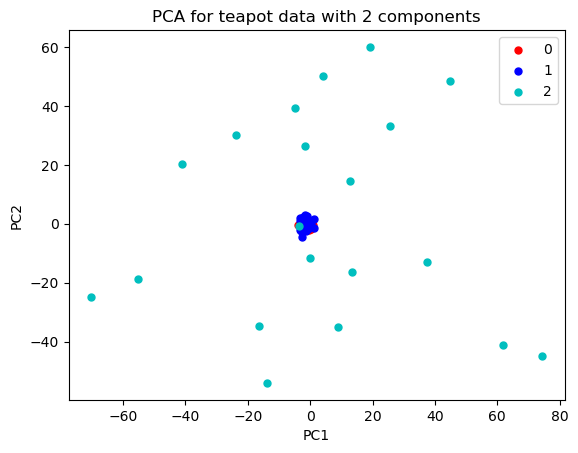

In [158]:
plt.scatter(X_pca[:, 0][:51], X_pca[:, 1][:51], c="r", s=25, cmap='plasma', label = "0")
plt.scatter(X_pca[:, 0][51:71], X_pca[:, 1][51:71], c="b", s=25, cmap='plasma', label = "1")
plt.scatter(X_pca[:, 0][71:], X_pca[:, 1][71:], c="c", s=25, cmap='plasma', label = "2")


plt.title('PCA for teapot data with 2 components')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim([-5,5])
#plt.ylim([-5,5])
plt.legend()
plt.show()
#plt.savefig("PCA.png")

In [ ]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 92), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 92), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
#plt.xticks(ticks=list(range(1, 14)))
plt.legend(loc='best')
plt.tight_layout()
#plt.xlim([-0.1, 60])
#plt.savefig("PCAhist.png")

In [ ]:
#LDA part

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

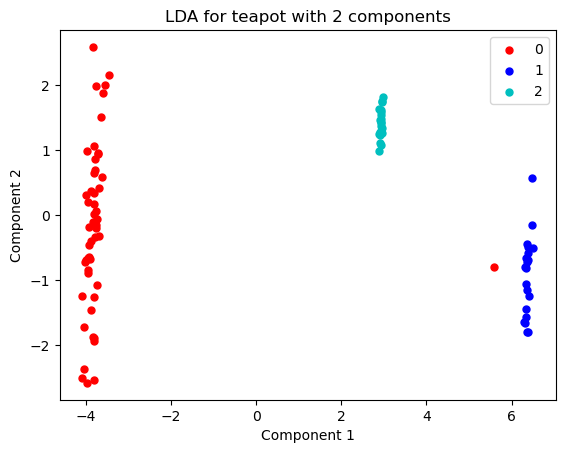

In [163]:
plt.scatter(X_lda[:, 0][:51], X_lda[:, 1][:51], c="r", s=25, cmap='plasma', label = "0")
plt.scatter(X_lda[:, 0][51:71], X_lda[:, 1][51:71], c="b", s=25, cmap='plasma', label = "1")
plt.scatter(X_lda[:, 0][71:], X_lda[:, 1][71:], c="c", s=25, cmap='plasma', label = "2")

plt.title('LDA for teapot with 2 components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
#plt.savefig("LDA.png")
plt.show()

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda.fit(X, y)

exp_var = lda.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 3), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 3), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Component index')
plt.xticks(ticks=[1, 2])
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("LDAhist")

In [150]:
#different generation model: the magnatude of cracked is not same, it increases
#and the number of the spots around same
#############################################################################################

littleCracked, sl, LittleCrackedPoints_2, Mesh = generation(10, 0, 80, 500,525)
midCracked, sm, MidCrackedPoints_2, Mesh= generation(cohort_size, 0, 50, 500,525)
midCracked2, sm2, MidCrackedPoints2_2, Mesh= generation(cohort_size, 1, 40, 500,525)
hardCracked, sh, HardCrackedPoints_2, Mesh = generation(cohort_size, 1, 25, 500,525)
hardCracked2, sh2, HardCrackedPoints2_2, Mesh = generation(cohort_size, 1, 10, 500,525)

OriginalPoints[0] = processed_shapes([OriginalPoints])
LittleCrackedPoints_2 = processed_shapes(LittleCrackedPoints_2)
MidCrackedPoints_2 = processed_shapes(MidCrackedPoints_2)
MidCrackedPoints2_2 = processed_shapes(MidCrackedPoints2_2)
HardCrackedPoints_2 = processed_shapes(HardCrackedPoints_2)
HardCrackedPoints2_2 = processed_shapes(HardCrackedPoints2_2)


#add 3 to every row, 3 means the number of the points in one cell.
Mesh = np.insert(Mesh, 0, 3, axis=1)

#save geometric data 
Data = np.concatenate((original, littleCracked, midCracked, midCracked2, hardCracked, hardCracked2), axis = 0)
df = pd.DataFrame(Data, columns=['Case', 'Volume', 'Area', 'Center_x', 'Center_y', 'Center_z', 'CenterOfMass_x', 'CenterOfMass_y', 'CenterOfMass_z'])


inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [151]:
DataPoints = np.zeros((4*cohort_size + 11, 3*(len(OriginalPoints))))

DataPoints[0] = np.concatenate((OriginalPoints[:, 0], OriginalPoints[:, 1], OriginalPoints[:,2]))
for i in range(10):
    DataPoints[1 +i] = np.concatenate((LittleCrackedPoints_2[i][:, 0], LittleCrackedPoints_2[i][:, 1], LittleCrackedPoints_2[i][:,2]))

for i in range(cohort_size) :
    DataPoints[11+i] = np.concatenate((MidCrackedPoints_2[i][:, 0], MidCrackedPoints_2[i][:, 1], MidCrackedPoints_2[i][:,2]))
    
for i in range(cohort_size) :
    DataPoints[31+i] = np.concatenate((MidCrackedPoints2_2[i][:, 0], MidCrackedPoints2_2[i][:, 1], MidCrackedPoints2_2[i][:,2]))
    
for i in range(cohort_size) :
    DataPoints[51+i] = np.concatenate((HardCrackedPoints_2[i][:, 0], HardCrackedPoints_2[i][:, 1], HardCrackedPoints_2[i][:,2]))
    
for i in range(cohort_size) :
    DataPoints[71+i] = np.concatenate((HardCrackedPoints2_2[i][:, 0], HardCrackedPoints2_2[i][:, 1], HardCrackedPoints2_2[i][:,2]))

#save it as dataframe and into excel table
df_points = pd.DataFrame(DataPoints)

In [153]:
#PCA part!!!!
X_2 = DataPoints

X_2 = StandardScaler().fit_transform(X_2)
y = np.zeros(91)
y[51:71] = 1
y[71:]  =2

ylabel = y.astype(str)  # Convert each element to a string

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(X_2)

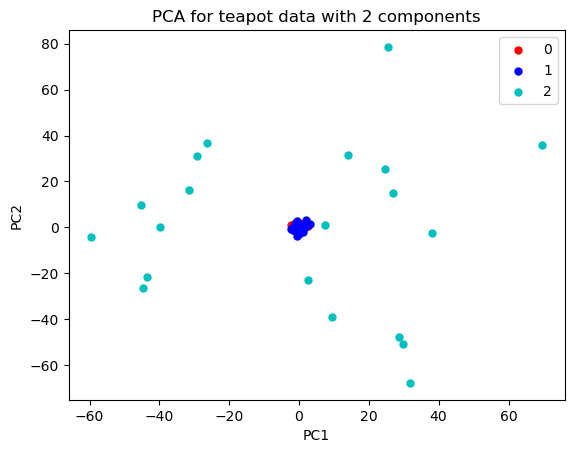

In [155]:
plt.scatter(X_pca2[:, 0][:51], X_pca2[:, 1][:51], c="r", s=25, cmap='plasma', label = "0")
plt.scatter(X_pca2[:, 0][51:71], X_pca2[:, 1][51:71], c="b", s=25, cmap='plasma', label = "1")
plt.scatter(X_pca2[:, 0][71:], X_pca2[:, 1][71:], c="c", s=25, cmap='plasma', label = "2")


plt.title('PCA for teapot data with 2 components')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim([-7,6])
#plt.ylim([-7,6])
plt.legend()
plt.show()
#plt.savefig("PCA.png")

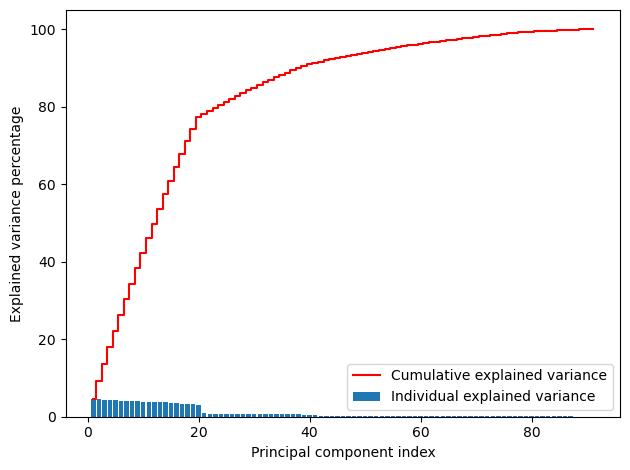

In [160]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 92), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 92), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
#plt.xticks(ticks=list(range(1, 14)))
plt.legend(loc='best')
plt.tight_layout()
#plt.xlim([-0.1, 60])
#plt.savefig("PCAhist.png")

In [161]:
#LDA part

lda2 = LinearDiscriminantAnalysis(n_components=2)
X_lda2 = lda.fit_transform(X, y)

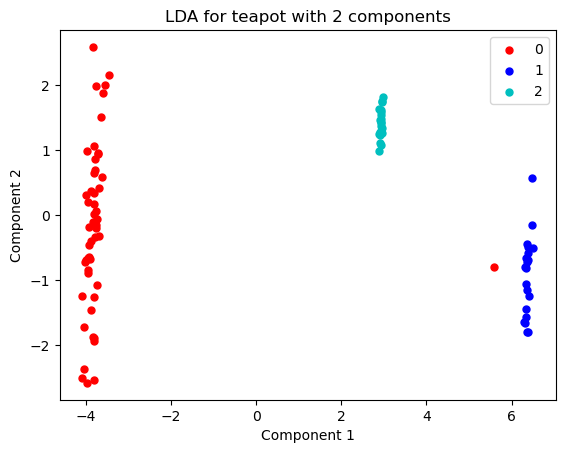

In [162]:
plt.scatter(X_lda2[:, 0][:51], X_lda2[:, 1][:51], c="r", s=25, cmap='plasma', label = "0")
plt.scatter(X_lda2[:, 0][51:71], X_lda2[:, 1][51:71], c="b", s=25, cmap='plasma', label = "1")
plt.scatter(X_lda2[:, 0][71:], X_lda2[:, 1][71:], c="c", s=25, cmap='plasma', label = "2")

plt.title('LDA for teapot with 2 components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
#plt.savefig("LDA.png")
plt.show()

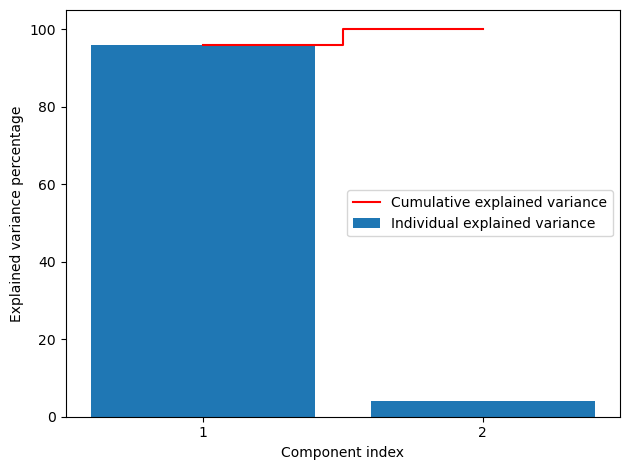

In [59]:
lda = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda.fit(X, y)

exp_var = lda.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 3), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 3), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Component index')
plt.xticks(ticks=[1, 2])
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("LDAhist")